In [12]:
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(6)

# Define the distance function
def distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Define the objective function
def objective_function(solution, facility_locations, customer_locations, facility_opening_costs):
    total_cost = 0
    for i, customer_location in enumerate(customer_locations):
        min_distance = float('inf')
        for j, facility_location in enumerate(facility_locations):
            if solution[j] == 1:
                d = distance(customer_location[0], customer_location[1],
                             facility_location[0], facility_location[1])
                if d < min_distance:
                    min_distance = d
        total_cost += min_distance
    total_cost += sum([facility_opening_costs[i] for i, s in enumerate(solution) if s == 1])
    return total_cost

# Define the Tabu Search function
def tabu_search(facility_locations, customer_locations, facility_opening_costs, tabu_size = 5, max_iter=100):
    # Initialize the solution and its cost
    solution = [random.randint(0, 1) for _ in range(len(facility_locations))]
    print(f'Initial Solution: {solution}')
    best_solution = solution.copy()
    best_cost = objective_function(best_solution, facility_locations, customer_locations, facility_opening_costs)

    # Initialize the tabu list
    tabu_moves = [0]*len(facility_locations)

    # Start the Tabu Search iterations
    for iteration in range(max_iter):
        # Generate the neighboring solutions
        neighbors = []
        for i in range(len(solution)):
            neighbor = solution.copy()
            neighbor[i] = 1 - neighbor[i]
            neighbors.append(neighbor)

        # Evaluate the neighboring solutions
        neighbor_costs = [objective_function(n, facility_locations, customer_locations,facility_opening_costs) for n in neighbors]

        # Choose the best neighbor that is not in the tabu list
        best_neighbor_cost = float('inf')
        for i, neighbor in enumerate(neighbors):
            if tabu_moves[i] < tabu_size and neighbor_costs[i] < best_neighbor_cost:
                best_neighbor_index = i
                best_neighbor = neighbor
                best_neighbor_cost = neighbor_costs[i]

        # Update the current solution
        solution = best_neighbor
        cost = best_neighbor_cost
        
        # Update the tabu moves
        tabu_moves = [max(j-1,0) if i != best_neighbor_index else tabu_size for i,j in enumerate(tabu_moves)]

        # Update the best solution found so far
        if cost < best_cost:
            best_solution = solution.copy()
            best_cost = cost

    return best_solution, best_cost

In [13]:
# Define the greedy heuristic function
def greedy_heuristic(facility_locations, customer_locations, facility_opening_costs):
    num_facilities = len(facility_locations)
    num_customers = len(customer_locations)

    # Sort the facilities according to opening cost
    facilities_sorted_index = np.argsort(facility_opening_costs)

    # Initialize the solution and its cost
    solution = [0] * num_facilities
    best_cost = float('inf')

    # Iterate over sorted facilities
    for i, j in enumerate(facilities_sorted_index):
      solution[j] = 1
      cost =  sum([facility_opening_costs[i] for i, s in enumerate(solution) if s == 1])

      # Iterate over customers
      for k in range(num_customers):
        min_distance = float('inf')

        # Iterate over number of facilities
        for f in range(num_facilities):
          if solution[f] == 1:
            d = distance(customer_locations[k][0], customer_locations[k][1],
                             facility_locations[f][0], facility_locations[f][1])
            if d < min_distance:
              min_distance = d
        cost += d

      if cost < best_cost:
          best_cost = cost
      else:
          solution[j] = 0
      cost = 0

    return solution, best_cost

In [14]:
def generate_locations(num_facilities, num_customers, decimals = 2):
    # Generate facility locations
    facility_locations = np.round(np.random.rand(num_facilities, 2),decimals=decimals)

    # Generate customer locations
    customer_locations = np.round(np.random.rand(num_customers, 2),decimals=decimals)

    # Generate facility opening costs
    facility_opening_costs = np.random.randint(1,4,size = num_facilities)

    return facility_locations.tolist(), customer_locations.tolist(), facility_opening_costs.tolist()

In [15]:
num_facilities = 50
num_customers = 50
np.random.seed(6)
facility_locations, customer_locations, facility_opening_costs = generate_locations(num_facilities, num_customers)

In [ ]:
start = time.time()
greedy_solution, greedy_cost = greedy_heuristic(facility_locations, customer_locations, facility_opening_costs)
end = time.time()
print(greedy_solution)
print(greedy_cost)
print(f'Time taken to complete the solution: {round(end-start,2)} second !')

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
24.839948006366757
Time taken to complete the solution: 0.03 second !


In [ ]:
def find_customers_assignment(solution, facility_locations, customer_locations):

  # Initilize dictionaries assigned to facilities
  cust = {index:[] for index in range(len(facility_locations))}
  loc = {index:[] for index in range(len(facility_locations))}

  for i, customer_location in enumerate(customer_locations):
    min_distance = float('inf')
    nearest_facility = None
    for j, facility_location in enumerate(facility_locations):
        if solution[j] == 1:
            d = distance(customer_location[0], customer_location[1],
                          facility_location[0], facility_location[1])
            if d < min_distance:
               
               nearest_facility = j
               min_distance = d
    cust[nearest_facility].append(i)
    loc[nearest_facility].append(customer_location)

  return cust, loc

In [ ]:
tabu_sizes = [5, 10, 15, 20, 30]
max_iterations = [100, 200, 300, 500, 1000]

df = pd.DataFrame(columns = ['tabu_size', 'max_iteration', 'cpu_time', 'cost'])
for tabu_size in tabu_sizes:
  for max_iteration in max_iterations:
    start = time.time()
    tabu_solution, tabu_cost = tabu_search(facility_locations, customer_locations,facility_opening_costs, tabu_size = tabu_size, max_iter = max_iteration)
    end = time.time()
    df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()

Initial Solution: [0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


Initial Solution: [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1]


<ipython-input-7-7dba5590dee4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'tabu_size':tabu_size, 'max_iteration':max_iteration, 'cpu_time': round(end-start,2), 'cost': tabu_cost}, ignore_index = True).copy()


In [ ]:
df.sort_values(by=['cost','cpu_time'],ascending=True)

,tabu_size,max_iteration,cpu_time,cost
5,10.0,100.0,3.36,13.591716
10,15.0,100.0,3.46,13.591716
15,20.0,100.0,3.50,13.591716
0,5.0,100.0,4.12,13.591716
16,20.0,200.0,6.38,13.591716
6,10.0,200.0,6.74,13.591716
1,5.0,200.0,7.68,13.591716
11,15.0,200.0,8.14,13.591716
7,10.0,300.0,9.76,13.591716
12,15.0,300.0,10.48,13.591716


In [ ]:
start = time.time()
tabu_solution, tabu_cost = tabu_search(facility_locations, customer_locations,facility_opening_costs, tabu_size = 15, max_iter = 100)
end = time.time()
print(tabu_solution)
print(tabu_cost)
print(f'Time taken to complete the solution: {round(end-start,2)} second !')

Initial Solution: [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
13.591715585472269
Time taken to complete the solution: 4.5 second !


In [ ]:
tabu_customers,tabu_customer_locations = find_customers_assignment(tabu_solution, facility_locations, customer_locations)
greedy_customers,greedy_customer_locations = find_customers_assignment(greedy_solution, facility_locations, customer_locations)

<ipython-input-14-5aefa6cc7edc>:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.array(axis)[:,0],np.array(axis)[:,1],c=color, s = 100, label = 'Customers')
<ipython-input-14-5aefa6cc7edc>:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.array(facility_locations)[fac,0],np.array(facility_locations)[fac,1], marker = '*', c = color, s= 150, label = 'Facilities')


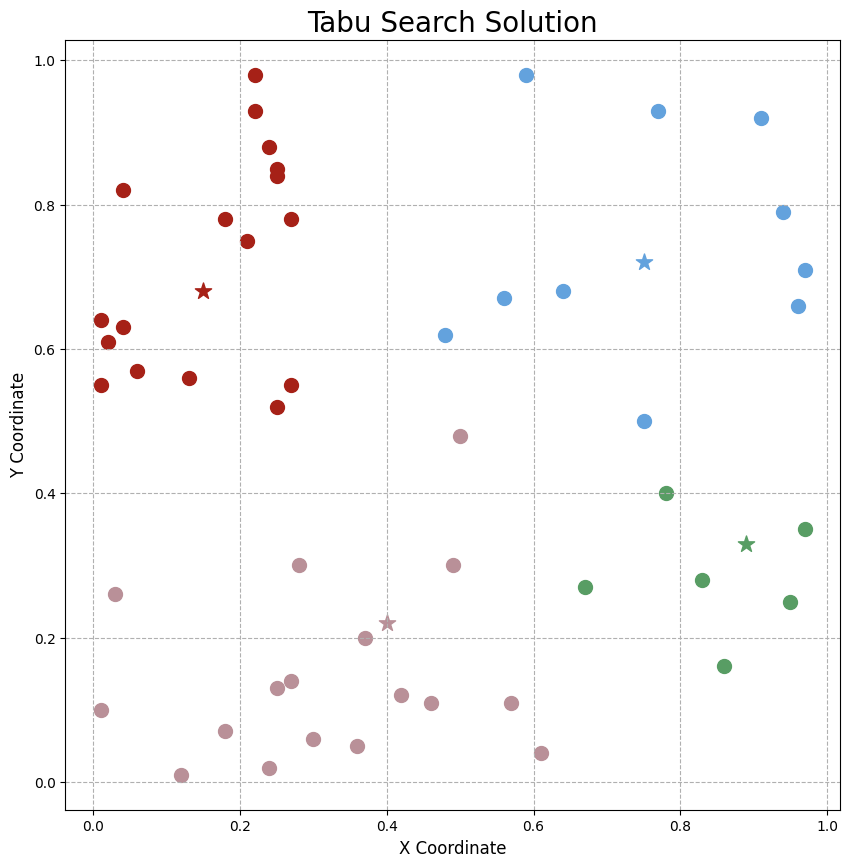

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Tabu Search Solution', fontsize=20)
plt.grid(linestyle='--')
plt.xlabel('X Coordinate', fontsize = 12)
plt.ylabel('Y Coordinate', fontsize = 12)
for fac, axis in tabu_customer_locations.items():
  if len(axis) > 0:
    color = np.random.rand(3,)
    plt.scatter(np.array(axis)[:,0],np.array(axis)[:,1],c=color, s = 100, label = 'Customers')
    plt.scatter(np.array(facility_locations)[fac,0],np.array(facility_locations)[fac,1], marker = '*', c = color, s= 150, label = 'Facilities')

<ipython-input-16-75235f12b99a>:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.array(axis)[:,0],np.array(axis)[:,1],c=color, s = 100, label = 'Customers')
<ipython-input-16-75235f12b99a>:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.array(facility_locations)[fac,0],np.array(facility_locations)[fac,1], marker = '*', c = color, s= 150, label = 'Facilities')


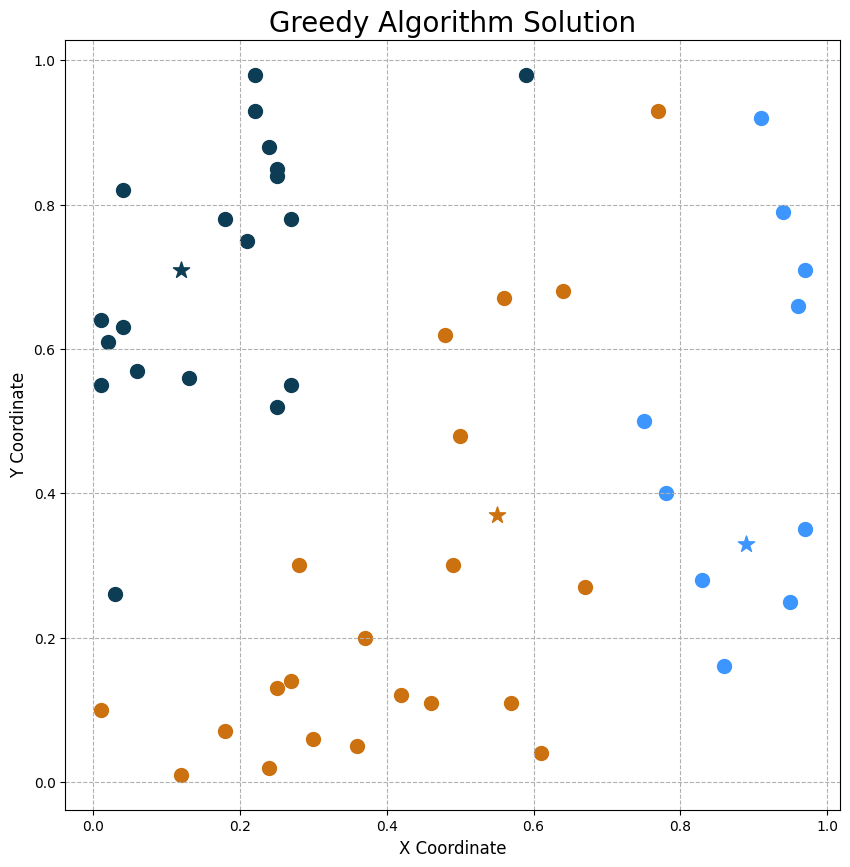

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Greedy Algorithm Solution', fontsize=20)
plt.grid(linestyle='--')
plt.xlabel('X Coordinate', fontsize = 12)
plt.ylabel('Y Coordinate', fontsize = 12)
for fac, axis in greedy_customer_locations.items():
  if len(axis) > 0:
    color = np.random.rand(3,)
    plt.scatter(np.array(axis)[:,0],np.array(axis)[:,1],c=color, s = 100, label = 'Customers')
    plt.scatter(np.array(facility_locations)[fac,0],np.array(facility_locations)[fac,1], marker = '*', c = color, s= 150, label = 'Facilities')

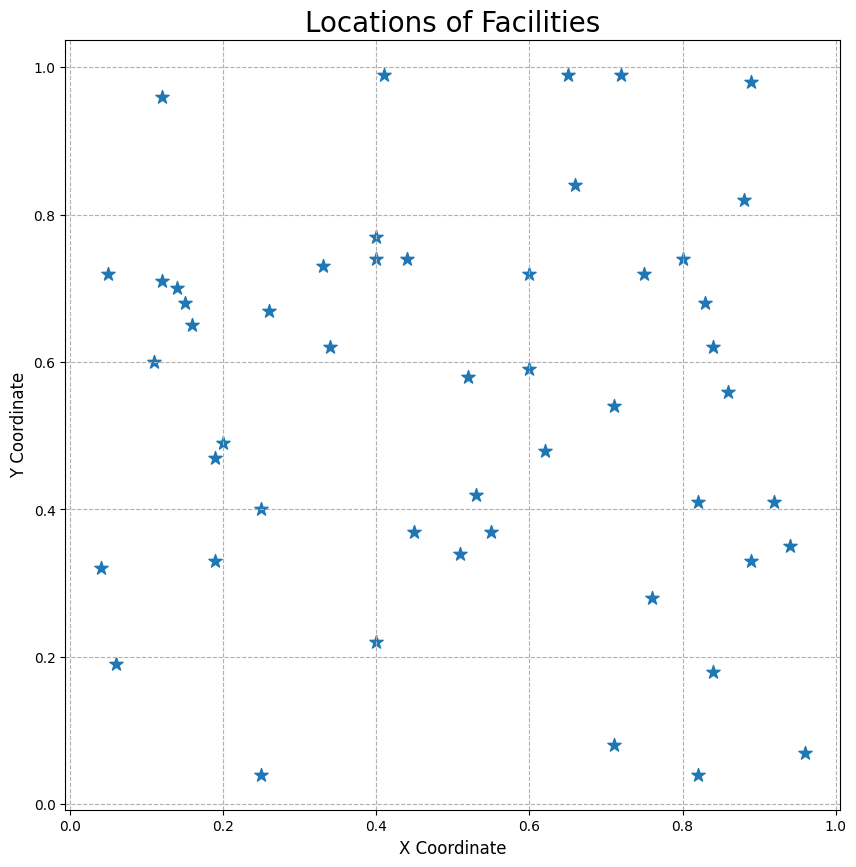

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Locations of Facilities', fontsize=20)
plt.grid(linestyle='--')
plt.xlabel('X Coordinate', fontsize = 12)
plt.ylabel('Y Coordinate', fontsize = 12)
plt.scatter(np.array(facility_locations)[:,0],np.array(facility_locations)[:,1], marker = '*', s = 100)

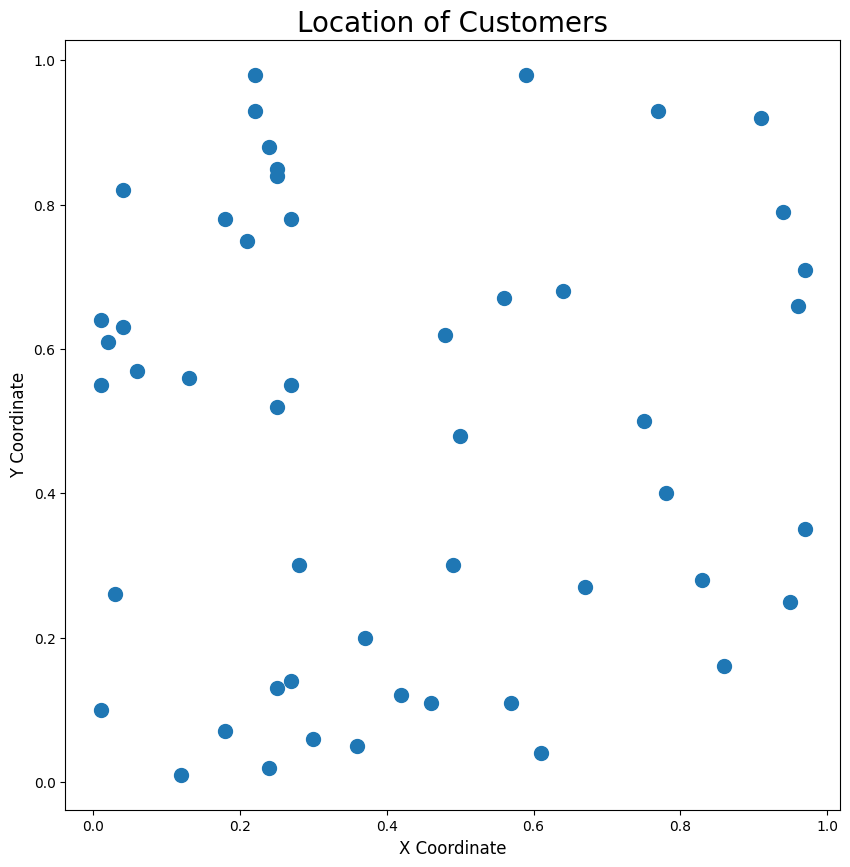

In [19]:
plt.figure(figsize=(10,10))
plt.title('Location of Customers', fontsize=20)
plt.xlabel('X Coordinate', fontsize = 12)
plt.ylabel('Y Coordinate', fontsize = 12)
plt.scatter(np.array(customer_locations)[:,0],np.array(customer_locations)[:,1], s = 100, label = 'Customers')